In [1]:
# The problem that is going to be addressed is the prediction of the adjust close value of stock price of Microsoft Corporation based on their historical data using a deep learning algorithm (LSTM) 
# The dataset that is going to be used, is accessible via https://www.kaggle.com/datasets/varpit94/microsoft-stock-data?resource=download
# The idea of problem and backbone of the code has been inspired from https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/
# I have also added XGBoost model to compare the result of this algorithm with LSTM to see for this problem which one could show better performance

In [2]:
#libraries
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from xgboost import XGBRegressor

C:\Users\mrjmf\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#parsing the dataset and store it into a pandas dataframe
df=pd.read_csv("MSFT.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,295.369995,301.000000,292.730011,300.429993,300.429993,43317000
2022-03-21,298.890015,300.140015,294.899994,299.160004,299.160004,28351200
2022-03-22,299.799988,305.000000,298.769989,304.059998,304.059998,27599700
2022-03-23,300.510010,303.230011,297.720001,299.489990,299.489990,25715400
2022-03-24,299.140015,304.200012,298.320007,304.100006,304.100006,24446900


In [4]:
#displaying the dimension of the dataset, and checking for null values
print("Dataframe dimension (rows, columns): ", df.shape)
print("null values existence: ", df.isnull().values.any())

Dataframe dimension (rows, columns):  (9083, 6)
null values existence:  False


In [5]:
# displaying basic statistical measures of the attributes
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9083.000000,9083.000000,9083.000000,9083.000000,9083.000000,9.083000e+03
mean,41.324936,41.760887,40.878488,41.335628,36.256120,5.875055e+07
std,59.696905,60.272218,59.081728,59.714567,59.981436,3.845200e+07
min,0.088542,0.092014,0.088542,0.090278,0.057046,2.304000e+06
25%,4.050781,4.102051,4.027344,4.075195,2.575089,3.461230e+07
50%,26.820000,27.100000,26.520000,26.840000,18.948530,5.203200e+07
75%,40.034999,40.443751,39.500000,39.937500,29.244812,7.265400e+07
max,344.619995,349.670013,342.200012,343.109985,342.402008,1.031789e+09


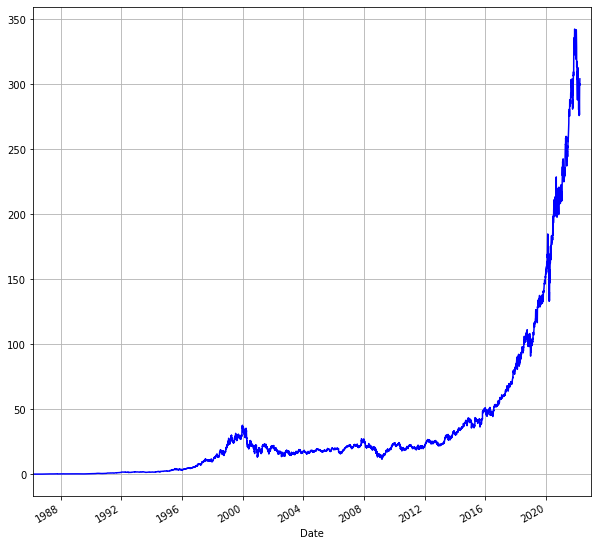

In [6]:
#Plotting true adj close values from march 1986 to december 2022 (data is just available till march of 2022 but to have a more clear plot, december 2022 has been chosen)
df['Adj Close'].plot(figsize = (10,10), kind = 'line', color = 'blue', grid = True, xlim = ['1986-03-13', '2022-12-22'])
plt.show()

In [7]:
#target or response variable
target = pd.DataFrame(df['Adj Close'])
#predictor variables
columns = ['Open', 'High', 'Low', 'Volume']

In [8]:
#Scaling the data using minmax scaler into [0,1] in order to make sure the model is not going to be sensitive about the data scale
scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(df[columns])
transformed_data= pd.DataFrame(columns=columns, data=transformed_data, index=df.index)
transformed_data.head()

,Open,High,Low,Volume
Date,,,,
1986-03-13,0.000000,0.000027,0.000000,1.000000
1986-03-14,0.000025,0.000030,0.000025,0.297096
1986-03-17,0.000035,0.000032,0.000036,0.127119
1986-03-18,0.000040,0.000032,0.000030,0.063588
1986-03-19,0.000033,0.000025,0.000025,0.044285


In [9]:
#Splitting to Training set and Test set 
timesplit= TimeSeriesSplit(n_splits=10) # defining 10-fold data splitting
for train_index, test_index in timesplit.split(transformed_data):
        X_train, X_test = transformed_data[:len(train_index)], transformed_data[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

#Process the data for LSTM (defining tensors as the input for the model)
trX =np.array(X_train)
tX =np.array(X_test)
X_train = trX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = tX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print("number of train samples: ",X_train.shape[0])
print("number of test samples: ", X_test.shape[0])

number of train samples:  8258
number of test samples:  825


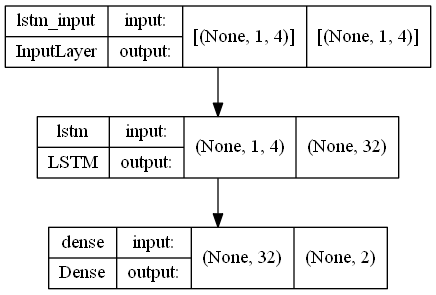

In [11]:
#Building the LSTM Model with the shapes provided in the previous cell, and rectified linear unit as activation function
#32 neurons and 1 dense layer LSTM architecture
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(2))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True) # plotting the model architecture

In [12]:
lstm_m=lstm.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, shuffle=False)

Epoch 1/100
517/517 [==============================] - 1s 1ms/step - loss: 463.9689
Epoch 2/100
517/517 [==============================] - 1s 1ms/step - loss: 262.0865
Epoch 3/100
517/517 [==============================] - 1s 1ms/step - loss: 240.5553
Epoch 4/100
517/517 [==============================] - 1s 1ms/step - loss: 226.4520
Epoch 5/100
517/517 [==============================] - 1s 1ms/step - loss: 201.0175
Epoch 6/100
517/517 [==============================] - 1s 1ms/step - loss: 167.2202
Epoch 7/100
517/517 [==============================] - 1s 1ms/step - loss: 128.7562
Epoch 8/100
517/517 [==============================] - 1s 1ms/step - loss: 91.4553
Epoch 9/100
517/517 [==============================] - 1s 1ms/step - loss: 59.8870
Epoch 10/100
517/517 [==============================] - 1s 1ms/step - loss: 36.3912
Epoch 11/100
517/517 [==============================] - 1s 1ms/step - loss: 21.1852
Epoch 12/100
517/517 [==============================] - 1s 1ms/step - loss: 12

517/517 [==============================] - 1s 1ms/step - loss: 2.7600
Epoch 100/100
517/517 [==============================] - 1s 1ms/step - loss: 2.7601


In [13]:
#Prediction of LSTM on the test data
y_pred= lstm.predict(X_test)

In [14]:
#r-squared of the model
print("R-squared score: ", r2_score(y_test, y_pred[:,0]))

#rmse of the model
print("Root Mean Squared Error: ",  mean_squared_error(y_test, y_pred[:,0], squared=False))

#MAE of the model
print("Mean Absolute Error:", sum((y_test - y_pred[:,0]))/len(y_test))

R-squared score:  0.7906880235105175
Root Mean Squared Error:  31.822917790926862
Mean Absolute Error: 25.404183409679227


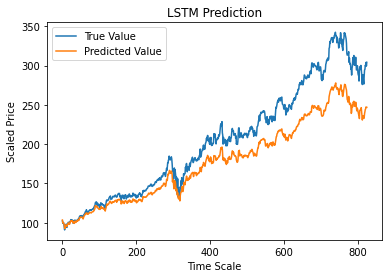

In [15]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred[:,0], label='Predicted Value')
plt.title('LSTM Prediction')
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

We can try extreme gradient boost model to see how it works for this dataset

In [16]:
XGB_model = XGBRegressor(n_estimators=1000)
XGB_model.fit(X_train[:,0], y_train)
y_pred_XGB = XGB_model.predict(X_test[:,0])

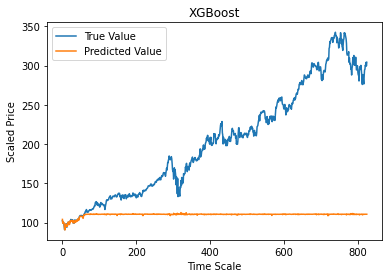

In [17]:
#Predicted vs True Adj Close Value – XGBoost
plt.plot(y_test, label='True Value')
plt.plot(y_pred_XGB, label='Predicted Value')
plt.title('XGBoost')
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

We can see that extreme gradient boost method is learning the trend of stock price very well at first, but after that it loses its exploration and low variance of the output for this problem is obvious through the plot.

LSTM works well in the case of this pattern recognition because its architecture to have memory and can use the output from the previous timestep as the input for the current timestep.